# Part 2/2: Predicting whether a semiconductor product will pass or fail using neural networks

## Rylan Larsen


As a follow-up to using non-neural network classifiers, I tested three neural network models classifiers on the Secom dataset. The goal here was to make a classifier which predicte the class (pass/fail) for the manufacturing product. In this dataset, there are very few failed examples. 

For the simple neural network, I used a single layer (no hidden) NN with a relu Function. This performed quite well (95% accuracy on test data). 

For the deep neural network, I added a hidden layer and also added hte ability to tweak the learning rate and momentum. The performance was actually worse for this network with the hidden layer (93%). The hyperparameters may need to be tweaked here.

For the LSTM, I had a LSTM of 50 neurons instead of a deep layer. This performed similarily to the DNN, with 93% accuracy. I'm not entirely sure the LSTM was the best choice for this data, since it was not-continously spaced time samples and this detail was not passed into the model.

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplot
import numpy as np

from tensorflow import keras
import tensorflow as tf

# Load Dataset and parse columns

In [2]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
names = ["feat" + str(x) for x in range(1, 591)]
secom_var = pd.read_csv(url, sep=" ", names=names, na_values = "NaN") 
 
 
url_l = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secom_labels = pd.read_csv(url_l,sep=" ",names = ["class","date"],parse_dates = ["date"],na_values = "NaN")

In [3]:
secom = pd.merge(secom_var, secom_labels,left_index=True,right_index=True)

In [4]:
secom.describe()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat582,feat583,feat584,feat585,feat586,feat587,feat588,feat589,feat590,class
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


In [142]:
print(np.shape(secom))

(1567, 592)


# Handle missing

There are a lot of attributes in this data set, let's explore how many of them have missing values:

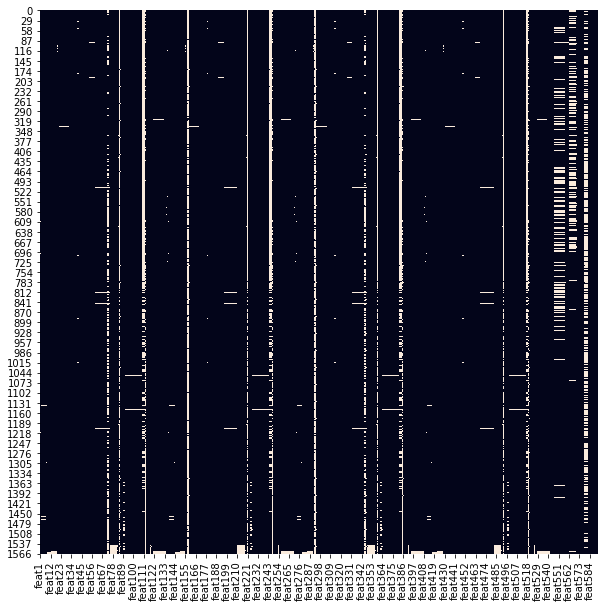

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(secom.isnull(), cbar=False,ax=ax);

Several of the columns are missing data the vast majority of the time. While we could encode the "missing" value as it's own type of variable for our feature selection, I'm going to remove features that are lacking more than 80% of their missing values and for the others, replace the misssing values by the median.

In [6]:
def replace_nan(df,cols,method='median',drop_columns_thresh=0.):
    '''Replace nan values in select pandas dataframe columns
    :Param df: dataframe to replace nans from
    :Param columns: columns to replace nans from
    :Param method: whether to use median or mean
    '''

    if drop_columns_thresh > 0.:
        if drop_columns_thresh > 1.:
            raise ('drop columns threshold is a percentage, cannot be greater than 1')
        
        drop_cols=list(df.columns[df.isnull().mean() > drop_columns_thresh])
        df.drop(drop_cols, axis=1)
        
    if method=='median':
        return df[cols].fillna(df.median())
    elif method=='mean':
        return df[cols].fillna(df.mean())
    

In [9]:
#get the columns of the dataframe
cols=list(secom.columns)
secom=replace_nan(secom,cols,drop_columns_thresh=0.8)
cols.remove('class')
cols.remove('date')


In [10]:
secom.describe()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat582,feat583,feat584,feat585,feat586,feat587,feat588,feat589,feat590,class
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,3014.441551,2495.866110,2200.551958,1395.383474,4.171281,100.0,101.116476,0.121825,1.462860,-0.000842,...,82.403069,0.500096,0.015317,0.003846,3.067628,0.021458,0.016474,0.005283,99.652345,-0.867262
std,73.480841,80.228143,29.380973,439.837330,56.103721,0.0,6.209385,0.008936,0.073849,0.015107,...,56.348694,0.003403,0.017174,0.003719,3.576899,0.012354,0.008805,0.002866,93.864558,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.665000,2452.885000,2181.099950,1083.885800,1.017700,100.0,97.937800,0.121100,1.411250,-0.010800,...,72.288900,0.497900,0.011600,0.003100,2.306500,0.013450,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.540000,2538.745000,2218.055500,1590.169900,1.518800,100.0,104.530000,0.123800,1.516850,0.008400,...,72.288900,0.502350,0.016500,0.004100,3.294950,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


Now that the missing values have been replaced, I want to try and understand how many of these attributes might be relevant to predicting the "class" for this dataset. To do this, I'm going to plot a heatmap of the correlation of each attribute with the class

# Split into test train data

In [203]:
X,y=secom[cols],secom['class']   

y=np.array(y).reshape(-1, 1).astype(np.float32)

In [204]:
from sklearn.preprocessing import MinMaxScaler

X = pd.DataFrame(MinMaxScaler().fit_transform(X)).astype(np.float32)
y=pd.DataFrame(MinMaxScaler().fit_transform(y)).astype(np.float32)

In [205]:
#split the data
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state=1)

print (np.shape(X_train))

(1018, 590)


# Single layer (simple) neural network classifier

In [166]:
#for our simple neural network, we will use a single layer with a RELU function

In [208]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, input_dim=np.shape(X_train)[1], activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['accuracy'])

In [209]:
history=model.fit(np.array(X_train), np.array(y_train), epochs=20)

Epoch 1/20
1018/1018 [==============================] - 1s 1ms/sample - loss: 0.0690 - acc: 0.9342
Epoch 2/20
1018/1018 [==============================] - 0s 142us/sample - loss: 0.0652 - acc: 0.9342
Epoch 3/20
1018/1018 [==============================] - 0s 145us/sample - loss: 0.0637 - acc: 0.9342
Epoch 4/20
1018/1018 [==============================] - 0s 146us/sample - loss: 0.0612 - acc: 0.9342
Epoch 5/20
1018/1018 [==============================] - 0s 143us/sample - loss: 0.0605 - acc: 0.9342
Epoch 6/20
1018/1018 [==============================] - 0s 145us/sample - loss: 0.0600 - acc: 0.9342
Epoch 7/20
1018/1018 [==============================] - 0s 145us/sample - loss: 0.0596 - acc: 0.9342
Epoch 8/20
1018/1018 [==============================] - 0s 147us/sample - loss: 0.0591 - acc: 0.9342
Epoch 9/20
1018/1018 [==============================] - 0s 145us/sample - loss: 0.0573 - acc: 0.9352
Epoch 10/20
1018/1018 [==============================] - 0s 139us/sample - loss: 0.0566 - acc

In [210]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Training accuracy ' + str(train_acc))

print('Test accuracy ' + str(test_acc))

Training accuracy 0.95284873
Test accuracy 0.92896175


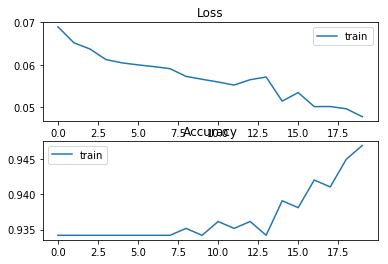

In [211]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.legend()


## DNN Classifer


For the deep neural network, I added hidden layers to the prevoius model.

In [228]:
#allow for parameters to adjust learning rate and momentum
sgd = keras.optimizers.SGD(lr=0.025, decay=1e-6, momentum=0.2)

DNN_model = keras.Sequential()
DNN_model.add(keras.layers.Dense(100, input_dim=np.shape(X_train)[1], activation='relu'))
DNN_model.add(keras.layers.Dense(50, activation=tf.nn.softmax))
DNN_model.add(keras.layers.Dense(1, activation='sigmoid'))

DNN_model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['accuracy'])

# Compile model
DNN_model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

DNN_history=DNN_model.fit(np.array(X_train), np.array(y_train), epochs=20,batch_size=20)

Epoch 1/20
1018/1018 [==============================] - 1s 963us/sample - loss: 0.2434 - acc: 0.6248
Epoch 2/20
1018/1018 [==============================] - 0s 152us/sample - loss: 0.2015 - acc: 0.9342
Epoch 3/20
1018/1018 [==============================] - 0s 155us/sample - loss: 0.1704 - acc: 0.9342
Epoch 4/20
1018/1018 [==============================] - 0s 156us/sample - loss: 0.1476 - acc: 0.9342
Epoch 5/20
1018/1018 [==============================] - 0s 163us/sample - loss: 0.1309 - acc: 0.9342
Epoch 6/20
1018/1018 [==============================] - 0s 159us/sample - loss: 0.1183 - acc: 0.9342
Epoch 7/20
1018/1018 [==============================] - 0s 156us/sample - loss: 0.1088 - acc: 0.9342
Epoch 8/20
1018/1018 [==============================] - 0s 156us/sample - loss: 0.1014 - acc: 0.9342
Epoch 9/20
1018/1018 [==============================] - 0s 159us/sample - loss: 0.0957 - acc: 0.9342
Epoch 10/20
1018/1018 [==============================] - 0s 156us/sample - loss: 0.0910 - a

In [229]:
_, train_acc = model_DNN.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_DNN.evaluate(X_test, y_test, verbose=0)

print('Training accuracy ' + str(train_acc))

print('Test accuracy ' + str(test_acc))

Training accuracy 0.9341847
Test accuracy 0.93260473


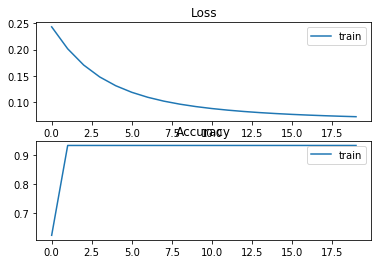

In [231]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(DNN_history.history['loss'], label='train')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(DNN_history.history['acc'], label='train')
pyplot.legend()

# RNN model (LSTM)

In [234]:
RNN_model = keras.Sequential()
RNN_model.add(keras.layers.Embedding(input_dim = np.shape(X_train)[1], output_dim = 50, input_length = np.shape(X_train)[1]))
RNN_model.add(keras.layers.LSTM(50))
RNN_model.add(keras.layers.Dense(1, activation='sigmoid'))
RNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 100)               59100     
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 101       
Total params: 59,201
Trainable params: 59,201
Non-trainable params: 0
_________________________________________________________________
None


In [235]:
RNN_history=RNN_model.fit(np.array(X_train), np.array(y_train), epochs=20)

Epoch 1/20
1018/1018 [==============================] - 23s 22ms/sample - loss: 0.4070 - acc: 0.9342
Epoch 2/20
1018/1018 [==============================] - 19s 19ms/sample - loss: 0.2462 - acc: 0.9342
Epoch 3/20
1018/1018 [==============================] - 21s 20ms/sample - loss: 0.2437 - acc: 0.9342
Epoch 4/20
1018/1018 [==============================] - 21s 21ms/sample - loss: 0.2434 - acc: 0.9342
Epoch 5/20
1018/1018 [==============================] - 20s 19ms/sample - loss: 0.2436 - acc: 0.9342
Epoch 6/20
1018/1018 [==============================] - 19s 19ms/sample - loss: 0.2436 - acc: 0.9342
Epoch 7/20
1018/1018 [==============================] - 20s 19ms/sample - loss: 0.2446 - acc: 0.9342
Epoch 8/20
1018/1018 [==============================] - 18s 18ms/sample - loss: 0.2450 - acc: 0.9342
Epoch 9/20
1018/1018 [==============================] - 20s 19ms/sample - loss: 0.2433 - acc: 0.9342
Epoch 10/20
1018/1018 [==============================] - 20s 20ms/sample - loss: 0.2449 - a

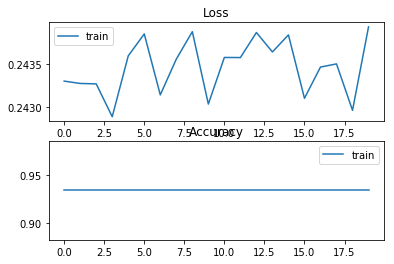

In [196]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(RNN_history.history['loss'], label='train')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(RNN_history.history['acc'], label='train')
pyplot.legend()

In [236]:
_, train_acc = RNN_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = RNN_model.evaluate(X_test, y_test, verbose=0)

print('Training accuracy ' + str(train_acc))

print('Test accuracy ' + str(test_acc))

Training accuracy 0.9341847
Test accuracy 0.93260473
